<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

# Sick vid

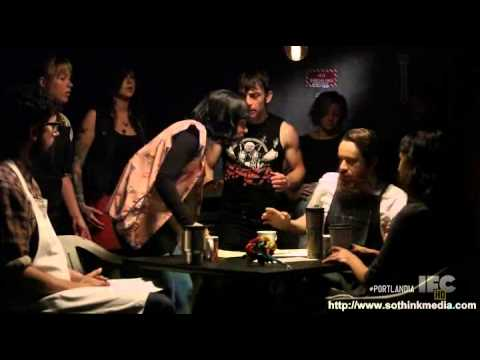

In [24]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

# Import data

In [25]:
%pwd

'/Users/isaacgrove/Development/DSu4s1/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [56]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## Data Cleaning

In [27]:
# Base
import re

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns


In [57]:
# Clean dates off of review text

reviews = shops['full_review_text'].tolist()
new_reviews = []
for review in reviews:
    new_reviews.append(review.split(None, 1)[-1])
shops['new_reviews_text'] = new_reviews

shops.head()

,coffee_shop_name,full_review_text,star_rating,new_reviews_text
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,1 check-in Love love loved the atmosphere! Eve...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"Listed in Date Night: Austin, Ambiance in Aust..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,1 check-in Listed in Brunch Spots I loved the ...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,Very cool decor! Good drinks Nice seating How...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,1 check-in They are located within the Northcr...


In [58]:
# Clean strings off of star rating

ratings = shops['star_rating'].tolist()
new_ratings = []
for rating in ratings:
    new_ratings.append(float(rating.split()[0]))
shops['star_rating_clean'] = new_ratings

shops.head()

,coffee_shop_name,full_review_text,star_rating,new_reviews_text,star_rating_clean
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,1 check-in Love love loved the atmosphere! Eve...,5.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"Listed in Date Night: Austin, Ambiance in Aust...",4.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,1 check-in Listed in Brunch Spots I loved the ...,4.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,Very cool decor! Good drinks Nice seating How...,2.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,1 check-in They are located within the Northcr...,4.0


In [59]:
shops['star_rating_clean'].value_counts(normalize=True)

5.0    0.496324
4.0    0.309874
3.0    0.096901
2.0    0.060399
1.0    0.036502
Name: star_rating_clean, dtype: float64

### Tokenize review text

In [60]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [51]:
nlp = spacy.load("en_core_web_lg")

In [64]:
# Use our "tokenize" function on the review text and put it in a new column

shops['tokenized_reviews'] = shops['new_reviews_text'].apply(tokenize)

In [65]:
shops.head(5)

,coffee_shop_name,full_review_text,star_rating,new_reviews_text,star_rating_clean,tokens,tokenized_reviews
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,1 check-in Love love loved the atmosphere! Eve...,5.0,"[1, checkin, love, love, loved, the, atmospher...","[1, checkin, love, love, loved, the, atmospher..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,"[listed, in, date, night, austin, ambiance, in...","[listed, in, date, night, austin, ambiance, in..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,1 check-in Listed in Brunch Spots I loved the ...,4.0,"[1, checkin, listed, in, brunch, spots, i, lov...","[1, checkin, listed, in, brunch, spots, i, lov..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,Very cool decor! Good drinks Nice seating How...,2.0,"[very, cool, decor, good, drinks, nice, seatin...","[very, cool, decor, good, drinks, nice, seatin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,1 check-in They are located within the Northcr...,4.0,"[1, checkin, they, are, located, within, the, ...","[1, checkin, they, are, located, within, the, ..."


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

### Overall Word / Token Count

In [67]:
# Analyze tokens
from collections import Counter

word_counts = Counter()

# Update it based on a split of each of the documents
shops['tokenized_reviews'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

We see that these are all stop words. We'll get rid of them soon.

In [68]:
# create a fuction which takes a corpus of document and returns a dataframe of word counts
def count(docs):
    
        # Instanstiate the Counter object
        word_counts = Counter()
        
        # Get the total number of words
        total_docs = len(docs)
        
        # Update the counter object
        for doc in docs:
            word_counts.update(doc)
        
        # Create a word count dataframe
        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])
        
        # Get the rank of the word
        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        
        # Get the total number of words
        total = wc['count'].sum()
        
        # Get the relative percentage of the word
        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        wc = wc.sort_values(by='rank')
        return wc

In [70]:
# Use the Function
wc = count(shops['tokenized_reviews'])
wc.head()

,word,count,rank,pct_total
4,the,34809,1.0,0.044975
15,and,26650,2.0,0.034433
49,a,22755,3.0,0.029401
19,i,20237,4.0,0.026147
44,to,17164,5.0,0.022177


In [71]:

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

In [72]:
tokenizer = Tokenizer(nlp.vocab)

In [74]:
# Tokenizer Pipe

tokens = []

for doc in tokenizer.pipe(shops['new_reviews_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['nlp_tokens'] = tokens
shops['nlp_tokens'].head()

0    [1, check-in, Love, love, loved, the, atmosphe...
1    [Listed, in, Date, Night:, Austin,, Ambiance, ...
2    [1, check-in, Listed, in, Brunch, Spots, I, lo...
3    [Very, cool, decor!, Good, drinks, Nice, seati...
4    [1, check-in, They, are, located, within, the,...
Name: nlp_tokens, dtype: object

In [75]:
# Count
wc = count(shops['nlp_tokens'])
wc.head()

,word,count,rank,pct_total
5,the,27779,1.0,0.034993
16,and,25748,2.0,0.032434
50,a,22085,3.0,0.027820
20,I,19780,4.0,0.024916
45,to,16904,5.0,0.021294


##### They're all still stop words. Let's get rid of them.

In [77]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['new_reviews_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['nlp_tokens'] = tokens

In [79]:
shops.nlp_tokens.head()

0    [1, check-in, love, love, loved, atmosphere!, ...
1    [listed, date, night:, austin,, ambiance, aust...
2    [1, check-in, listed, brunch, spots, loved, ec...
3    [cool, decor!, good, drinks, nice, seating,  ,...
4    [1, check-in, located, northcross, mall, shopp...
Name: nlp_tokens, dtype: object

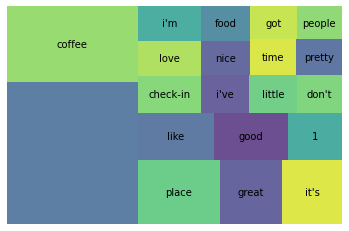

In [80]:
# Let's visualize our first worthy, default-stopword-free token counts

wc = count(shops['nlp_tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [110]:
# Let's add a few stop words of our own

STOP_WORDS = nlp.Defaults.stop_words.union([' ','1', 'coffee', 'place', 'food', 'i\'m', 'i\'ve', '-', 'it\'s', 'coffee.'])

In [111]:
tokens = []

for doc in tokenizer.pipe(shops['new_reviews_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['nlp_tokens'] = tokens

In [112]:
wc = count(shops['nlp_tokens'])
wc.head()

,word,count,rank,pct_total
143,great,3250,1.0,0.008775
186,like,2902,2.0,0.007835
158,good,2779,3.0,0.007503
0,check-in,1961,4.0,0.005295
1,love,1806,5.0,0.004876


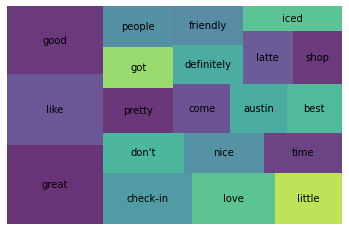

In [113]:
wc = count(shops['nlp_tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

### View Counts By Rating

In [118]:
# separate shops by rating. 4-5 stars is good, 1-3 is bad.

good_shops = shops[shops['star_rating_clean'] >= 4.0]
bad_shops = shops[shops['star_rating_clean'] < 4.0]

print(good_shops.shape)
print(bad_shops.shape)
print(shops.shape)

(6140, 8)
(1476, 8)
(7616, 8)


In [134]:
# top words for 'good' shops
wc = count(good_shops['nlp_tokens'])
wc_top20 = wc[wc['rank'] <= 20]
wc_top20

,word,count,rank,pct_total
143,great,2902,1.0,0.010073
311,good,2180,2.0,0.007567
238,like,2068,3.0,0.007178
1,love,1604,4.0,0.005567
0,check-in,1602,5.0,0.005560
596,little,1230,6.0,0.004269
250,nice,1101,7.0,0.003822
447,best,1093,8.0,0.003794
170,friendly,1014,9.0,0.003520
47,austin,1013,10.0,0.003516


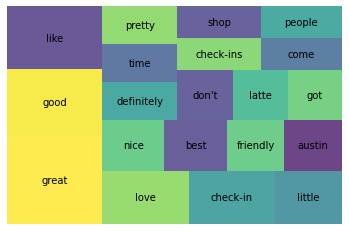

In [135]:
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [138]:
# top words for 'bad shops'
wc = count(bad_shops['nlp_tokens'])
wc_top20 = wc[wc['rank'] <= 20]
wc_top20

,word,count,rank,pct_total
33,like,834,1.0,0.010138
2,good,599,2.0,0.007281
208,don't,430,3.0,0.005227
38,check-in,359,4.0,0.004364
218,time,351,5.0,0.004267
60,pretty,349,6.0,0.004242
69,great,348,7.0,0.004230
521,people,327,8.0,0.003975
30,service,314,9.0,0.003817
28,got,300,10.0,0.003647


##### Reading down through this list of top 20 common words in bad shops, a coherent story almost emerges by itself.
I would reason that the number 1 complaint in bad reviews is that their drink/order didn't come, or that it didn't come on time. Contrasting with the list of "good" reviews, these are the only sentiments that are different. Even in bad reviews, peopple are quick to mention that they are happy with the shop workers.

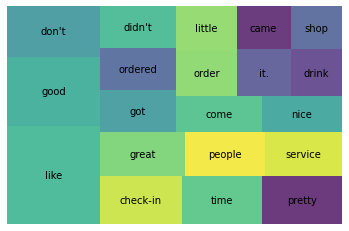

In [137]:
# top words for bad shops

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [130]:
# Define a function to get lemmas

def get_lemmas(text):
    '''gets lemmas for a given doc's tokens. Cleans pronouns, punctuation, and stop words '''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.text.lower() not in STOP_WORDS) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [131]:
# Apply get_lemmas to review text.
# Note this is basically a retokenization.

shops['lemmas'] = shops['new_reviews_text'].apply(get_lemmas)
shops['lemmas'].head()

0    [check, Love, love, love, atmosphere, corner, ...
1    [list, Date, Night, Austin, Ambiance, Austin, ...
2    [check, list, Brunch, Spots, love, eclectic, h...
3    [cool, decor, good, drink, nice, seating, over...
4    [check, locate, Northcross, mall, shopping, ce...
Name: lemmas, dtype: object

In [132]:
shops.head(2)

,coffee_shop_name,full_review_text,star_rating,new_reviews_text,star_rating_clean,tokens,tokenized_reviews,nlp_tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,1 check-in Love love loved the atmosphere! Eve...,5.0,"[1, checkin, love, love, loved, the, atmospher...","[1, checkin, love, love, loved, the, atmospher...","[check-in, love, love, loved, atmosphere!, cor...","[check, Love, love, love, atmosphere, corner, ..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,"[listed, in, date, night, austin, ambiance, in...","[listed, in, date, night, austin, ambiance, in...","[listed, date, night:, austin,, ambiance, aust...","[list, Date, Night, Austin, Ambiance, Austin, ..."


In [139]:
good_shops = shops[shops['star_rating_clean'] >= 4.0]
bad_shops = shops[shops['star_rating_clean'] < 4.0]

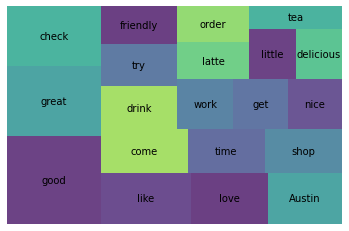

In [140]:
# good shops using lemmas

wc = count(good_shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

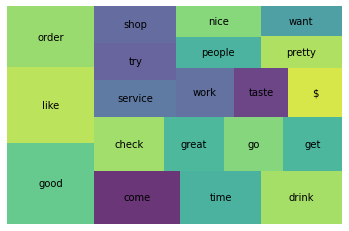

In [141]:
# bad shops using lemmas

wc = count(bad_shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [142]:
# Aggregate the words used in good and bad reviews, respectively
wc_good = count(good_shops['lemmas'])
wc_bad = count(bad_shops['lemmas'])

wc = pd.merge(wc_good, wc_bad, how='outer', on='word', suffixes=('_good', '_bad'))
wc.head()

,word,count_good,rank_good,pct_total_good,count_bad,rank_bad,pct_total_bad
0,good,4344.0,1.0,0.016251,1000.0,1.0,0.013311
1,great,3455.0,2.0,0.012925,462.0,8.0,0.006150
2,check,2942.0,3.0,0.011006,526.0,7.0,0.007002
3,like,2434.0,4.0,0.009106,945.0,2.0,0.012579
4,love,2069.0,5.0,0.007740,245.0,36.0,0.003261


In [146]:
wc['rel_count_good'] = wc['count_good'] / len(good_shops)

In [147]:
wc['rel_count_bad'] = wc['count_bad'] / len(bad_shops)

In [148]:
wc.head()

,word,count_good,rank_good,pct_total_good,count_bad,rank_bad,pct_total_bad,difference,rel_count_good,rel_count_bad
1,great,3455.0,2.0,0.012925,462.0,8.0,0.006150,0.006776,0.562704,0.313008
16,order,1370.0,17.0,0.005125,759.0,3.0,0.010103,0.004978,0.223127,0.514228
4,love,2069.0,5.0,0.007740,245.0,36.0,0.003261,0.004479,0.336971,0.165989
2,check,2942.0,3.0,0.011006,526.0,7.0,0.007002,0.004005,0.479153,0.356369
5,Austin,1988.0,6.0,0.007437,288.0,27.0,0.003834,0.003604,0.323779,0.195122


In [143]:
# Fill in NaNs with 0
wc = wc.fillna(0)

In [149]:
# Find difference in word freqs, sort by that difference

wc['rel_difference'] = abs(wc['rel_count_good'] - wc['rel_count_bad'])
wc = wc.sort_values(by=['rel_difference'], ascending=False)
wc.head()

,word,count_good,rank_good,pct_total_good,count_bad,rank_bad,pct_total_bad,difference,rel_count_good,rel_count_bad,rel_difference
16,order,1370.0,17.0,0.005125,759.0,3.0,0.010103,0.004978,0.223127,0.514228,0.291101
1,great,3455.0,2.0,0.012925,462.0,8.0,0.006150,0.006776,0.562704,0.313008,0.249695
3,like,2434.0,4.0,0.009106,945.0,2.0,0.012579,0.003473,0.396417,0.640244,0.243827
4,love,2069.0,5.0,0.007740,245.0,36.0,0.003261,0.004479,0.336971,0.165989,0.170982
82,$,553.0,83.0,0.002069,381.0,16.0,0.005071,0.003003,0.090065,0.258130,0.168065


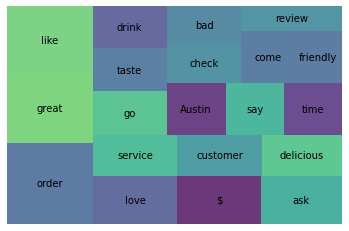

In [150]:
# Visualize top 20 greatest differences

# With this one, we found a word in a % of good reviews, a % of bad reviews, 
# found the biggest difference, and plotted those 20 words.
# So we've done "instances of the word per review"

wc_top20_diff = wc.head(n=20)

# Visualize
squarify.plot(sizes=wc_top20_diff['rel_difference'], label=wc_top20_diff['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [151]:
# Add the column 'difference', and get the absolute value of it
wc['difference'] = abs(wc['pct_total_good'] - wc['pct_total_bad'])
wc = wc.sort_values(by=['difference'], ascending=False)
wc.head()

,word,count_good,rank_good,pct_total_good,count_bad,rank_bad,pct_total_bad,difference,rel_count_good,rel_count_bad,rel_difference
1,great,3455.0,2.0,0.012925,462.0,8.0,0.006150,0.006776,0.562704,0.313008,0.249695
16,order,1370.0,17.0,0.005125,759.0,3.0,0.010103,0.004978,0.223127,0.514228,0.291101
4,love,2069.0,5.0,0.007740,245.0,36.0,0.003261,0.004479,0.336971,0.165989,0.170982
2,check,2942.0,3.0,0.011006,526.0,7.0,0.007002,0.004005,0.479153,0.356369,0.122785
5,Austin,1988.0,6.0,0.007437,288.0,27.0,0.003834,0.003604,0.323779,0.195122,0.128657


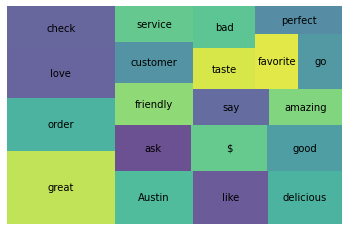

In [152]:
# In this approach, we use pct_total from count function and compare those percentages
# between good and bad reviews.
# This gives a slightly different visualization with mostly the same results.
wc_top20_diff = wc.head(n=20)

# Visualize
squarify.plot(sizes=wc_top20_diff['difference'], label=wc_top20_diff['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

